# TALOS Optimization - FIVE

An implementation of a hyperparameter grid search using the Talos library.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import talos

Using TensorFlow backend.
/home/jacobscottanthony/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jacobscottanthony/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jacobscottanthony/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jacobscottanthony/.local/l

### Check what hardware is available to Keras

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9614274374224652803
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18147710963669015094
physical_device_desc: "device: XLA_CPU device"
]


## Load and Split Data

In [3]:
if True:
    keep_col = list(range(1,18))

    df_day = pd.read_csv('ECL_Clean_Day.csv', 
                     infer_datetime_format=True,
                     parse_dates=['Timestamp'], 
                     index_col=['Timestamp'],
                     usecols = keep_col,
                     date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    #df_min.dtypes
    print (df_day.shape)
    df_day.head(5)

(5031, 16)


In [4]:
# create 10 years of data from 2019 - 2010
day_data = df_day[df_day.index >= '2010-01-01']

#split 7 years train, 3 years test
day_train = day_data[day_data.index <= '2017-01-01']
day_test = day_data[day_data.index >= '2017-01-01']

In [5]:
base_train = day_train['Close'] 
base_test = day_test['Close']

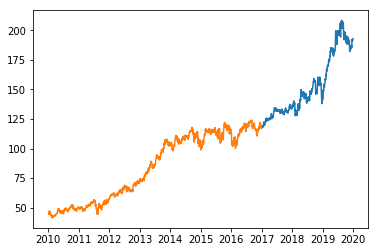

In [6]:
plt.plot(base_test)
plt.plot(base_train)
plt.show()

## Demonstrate Simple Vanilla Implementation

In [7]:
# Multi-step data preparation

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# define input sequence
#raw_seq = list(base_test[:100].values)
# choose a number of time steps
n_steps_in, n_steps_out = 30, 30
# split into samples
X_train, y_train = split_sequence(base_train.values, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(base_test.values, n_steps_in, n_steps_out) #length must be > n_in + n_out
# summarize the data
#for i in range(len(X)):
#    print(X[i], y[i])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1703, 30) (1703, 30) (695, 30) (695, 30)


In [8]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
#print (X_train.shape)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
#print (X_test.shape)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 43,830
Trainable params: 43,830
Non-trainable params: 0
_________________________________________________________________

Train on 1703 samples, validate on 695 samples
Epoch 1/20
1703/1703 [==============================] - 3s 2ms/step - loss: 3093.6669 - val_loss: 5058.6756
Epoch 2/20
1703/1703 [==============================] - 2s 1ms/step - loss: 650.7626 - val_loss: 694.1269
Epoch 3/20
1703/1703 [==============================] - 2s 1ms/step - loss: 265.6385 - val_loss: 267.4794
Epoch 4/20
1703/1703 [==============================] - 2s 1ms/step - loss: 93.7279 - val_loss: 289.7618
Epoch 5/20
1703/1703 [=================

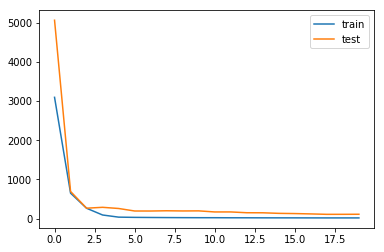

In [9]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Stacked LSTM

In [10]:
#params for grid search

p = {'LSTM_n' : [100, 200, 400],
    'LSTM_dropout' : [0, 0.1, 0.2],
    'dense_n' : [101, 201, 401],
    'dense_dropout' : [0, 0.11, 0.22],
    'batch_size' : [30, 60, 90, 120],
}

In [11]:
def LSTM_model(X_train, y_train, X_test, y_test, params):
    model = Sequential()                            
    model.add(LSTM(params['LSTM_n'], activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(Dropout(params['LSTM_dropout']))
    model.add(LSTM(params['LSTM_n'], activation='relu', return_sequences=True))
    model.add(Dropout(params['LSTM_dropout']))
    model.add(LSTM(params['LSTM_n'], activation='relu'))
    model.add(Dropout(params['LSTM_dropout']))
    model.add(Dense(params['dense_n']))
    model.add(Dropout(params['dense_dropout']))
    model.add(Dense(params['dense_n']))
    model.add(Dropout(params['dense_dropout']))
    model.add(Dense(params['dense_n']))
    model.add(Dropout(params['dense_dropout']))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='Adam', 
                  loss='mse')
    print (model.summary())
    
    #Early Stopping to avoid wasting time on bad hyperparams
    es = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

    out = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=1,
                    batch_size=params['batch_size'],
                    callbacks=[es],
                    validation_data=[X_test, y_test])
    
    return out, model

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

scan_object = talos.Scan(X_train,
                         y_train, 
                         params=p,
                         model=LSTM_model,
                         experiment_name='LSTM',
                         fraction_limit=0.03,
                         print_params=True)

  0%|          | 0/9 [00:00<?, ?it/s]

{'LSTM_dropout': 0, 'batch_size': 60, 'dense_dropout': 0.22, 'dense_n': 401, 'LSTM_n': 200}
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
____________________________

 11%|█         | 1/9 [03:40<29:24, 220.52s/it]

{'LSTM_dropout': 0, 'batch_size': 90, 'dense_dropout': 0, 'dense_n': 401, 'LSTM_n': 400}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_______________________________

 22%|██▏       | 2/9 [16:29<44:55, 385.09s/it]

{'LSTM_dropout': 0.2, 'batch_size': 90, 'dense_dropout': 0.22, 'dense_n': 201, 'LSTM_n': 100}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________________________

 33%|███▎      | 3/9 [18:39<30:51, 308.51s/it]

{'LSTM_dropout': 0, 'batch_size': 90, 'dense_dropout': 0, 'dense_n': 401, 'LSTM_n': 100}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_______________________________

 44%|████▍     | 4/9 [21:39<22:29, 269.96s/it]

{'LSTM_dropout': 0.1, 'batch_size': 60, 'dense_dropout': 0.22, 'dense_n': 201, 'LSTM_n': 200}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
__________________________

Epoch 56/100
1192/1192 [==============================] - 4s 4ms/step - loss: 720.6591 - val_loss: 344.5506


 56%|█████▌    | 5/9 [26:06<17:56, 269.24s/it]

{'LSTM_dropout': 0.2, 'batch_size': 30, 'dense_dropout': 0.11, 'dense_n': 101, 'LSTM_n': 400}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
__________________________

 67%|██████▋   | 6/9 [39:18<21:17, 425.86s/it]

{'LSTM_dropout': 0, 'batch_size': 120, 'dense_dropout': 0, 'dense_n': 401, 'LSTM_n': 100}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
______________________________

1192/1192 [==============================] - 2s 2ms/step - loss: 19.3522 - val_loss: 19.5695
Epoch 58/100
1192/1192 [==============================] - 2s 2ms/step - loss: 18.8254 - val_loss: 18.7759
Epoch 59/100
1192/1192 [==============================] - 2s 2ms/step - loss: 18.5754 - val_loss: 18.3615
Epoch 60/100
1192/1192 [==============================] - 2s 2ms/step - loss: 18.2093 - val_loss: 18.7248
Epoch 61/100
1192/1192 [==============================] - 2s 2ms/step - loss: 18.0814 - val_loss: 18.8294
Epoch 62/100
1192/1192 [==============================] - 2s 2ms/step - loss: 19.1290 - val_loss: 20.1408
Epoch 63/100
1192/1192 [==============================] - 2s 2ms/step - loss: 19.5887 - val_loss: 19.2695
Epoch 64/100
1192/1192 [==============================] - 2s 2ms/step - loss: 19.2591 - val_loss: 19.8213
Epoch 65/100
1192/1192 [==============================] - 2s 2ms/step - loss: 18.7049 - val_loss: 19.0528
Epoch 66/100
1192/1192 [==============================] - 2

 78%|███████▊  | 7/9 [42:49<12:02, 361.49s/it]

{'LSTM_dropout': 0.1, 'batch_size': 120, 'dense_dropout': 0.11, 'dense_n': 201, 'LSTM_n': 100}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________

 89%|████████▉ | 8/9 [44:27<04:42, 282.29s/it]

{'LSTM_dropout': 0, 'batch_size': 120, 'dense_dropout': 0.22, 'dense_n': 101, 'LSTM_n': 400}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
___________________________

Epoch 55/100
1192/1192 [==============================] - 8s 7ms/step - loss: 2857.3021 - val_loss: 1008.7034
Epoch 56/100
1192/1192 [==============================] - 8s 7ms/step - loss: 2860.6513 - val_loss: 1128.8852
Epoch 57/100
1192/1192 [==============================] - 8s 7ms/step - loss: 2906.7029 - val_loss: 1144.8188
Epoch 58/100
1192/1192 [==============================] - 8s 7ms/step - loss: 2810.6969 - val_loss: 1068.3798
Epoch 59/100
1192/1192 [==============================] - 8s 7ms/step - loss: 2838.6292 - val_loss: 1014.7039
Epoch 60/100
1192/1192 [==============================] - 8s 7ms/step - loss: 2838.3082 - val_loss: 979.4674
Epoch 61/100
1192/1192 [==============================] - 8s 7ms/step - loss: 2799.4595 - val_loss: 1012.6876
Epoch 62/100
1192/1192 [==============================] - 8s 7ms/step - loss: 2789.3747 - val_loss: 1178.8238
Epoch 63/100
1192/1192 [==============================] - 8s 7ms/step - loss: 2760.5818 - val_loss: 1036.5405
Epoch 64/10

100%|██████████| 9/9 [58:02<00:00, 386.90s/it]


There is a bug (link below) in the Talos library that means it sorts the columns and values from parameter dictionary incorrectly in the ```talos.Analze``` object. That is why each hyperparameter has unique values so I can easily understand the results.

[https://github.com/autonomio/talos/issues/439]

In [13]:
analyze_object = talos.Analyze(scan_object)
df = analyze_object.data
df.sort_values(by=['val_loss'])

,round_epochs,val_loss,loss,LSTM_dropout,LSTM_n,batch_size,dense_dropout,dense_n
6,100,17.747945,17.063383,0.0,120,0.00,401,100
3,70,18.036368,12.276716,0.0,90,0.00,401,100
7,41,118.781533,1501.891289,0.1,120,0.11,201,100
1,100,229.086226,249.266560,0.0,90,0.00,401,400
4,56,344.550551,720.659121,0.1,60,0.22,201,200
0,47,537.265257,1979.447426,0.0,60,0.22,401,200
2,49,596.352055,471.765609,0.2,90,0.22,201,100
5,59,610.984471,1305.146822,0.2,30,0.11,101,400
8,100,647.572393,2425.837471,0.0,120,0.22,101,400


## Results
* I like the look of the first two results. The features include:
  * LSTM neurons 100
  * No dropout on LSTM layers
  * Dense neurons of 400
  * No dropout on Dense layers
  * Higher batch sizes of 90 or 120